# Partly independent model with probability distribution prediction

One shared MLP and 22 independent models (11 for mean and 11 for standard deviation)

In [1]:
import json

from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params

from pprint import pprint
from astropy.io import fits

### Load data

In [2]:
refer_path = '../data/reference.fits'
refer, names = open_param_file(refer_path)

In [5]:
path_to_json = '../res_experiments/hps_partly_independent_dist_mlp.json'
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'activation': 'elu',
 'batch_norm': True,
 'batch_size': 128,
 'bottom_net': 'BottomMLPNet',
 'bottom_output': 100,
 'cont_scale': 40000,
 'dropout': 0.05,
 'factors': [1, 1000, 1000, 1000],
 'hidden_dims': [100, 100],
 'hps_name': 'hps_partly_independent_dist_mlp',
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'predict_ind': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'source': 'database',
 'top_layers': 2,
 'top_net': 'TopIndependentDistributionNet',
 'top_output': 11,
 'trainset': None,
 'transform_type': 'mlp_transform_rescale',
 'val_split': 0.01,
 'valset': None}


In [6]:
params = fits.open('../data/small_parameters_base.fits')[0].data

In [7]:
# model hyperparameters
hps = HyperParams.from_file(path_to_json=path_to_json)

## Model training

### Model training on a small part of dataset

In [8]:
# hps.n_epochs = 1
model = Model(hps)
# model.net

In [9]:
history = model.train(data_arr=params)

epoch:  20%|██        | 1/5 [00:01<00:05,  1.50s/it]


Epoch 001 train_loss: 12.1162 val_loss 1.0411



epoch:  40%|████      | 2/5 [00:02<00:04,  1.38s/it]


Epoch 002 train_loss: 1.0546 val_loss 1.0221



epoch:  60%|██████    | 3/5 [00:04<00:02,  1.33s/it]


Epoch 003 train_loss: 1.0308 val_loss 0.9923



epoch:  80%|████████  | 4/5 [00:05<00:01,  1.25s/it]


Epoch 004 train_loss: 1.0029 val_loss 0.9635



epoch: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 005 train_loss: 0.9732 val_loss 0.9336


In [10]:
predicted_common = model.predict_refer('../data/reference.fits')

100%|██████████| 248/248 [00:33<00:00,  7.33it/s]


In [11]:
df_ind = compute_metrics(refer, predicted_common, names)
df_ind

,r2,mse,mae
Field_Strength,0.126,0.123,0.295
Field_Inclination,0.023,0.251,0.472
Field_Azimuth,0.005,0.219,0.391
Doppler_Width,0.001,0.032,0.135
Damping,0.023,0.027,0.115
Line_Strength,0.032,0.115,0.287
Original_Continuum_Intensity,0.520,0.435,0.640
Source_Function_Gradient,0.121,0.095,0.282
Doppler_Shift2,0.001,0.388,0.616
Stray_Light_Fill_Factor,0.339,0.452,0.575


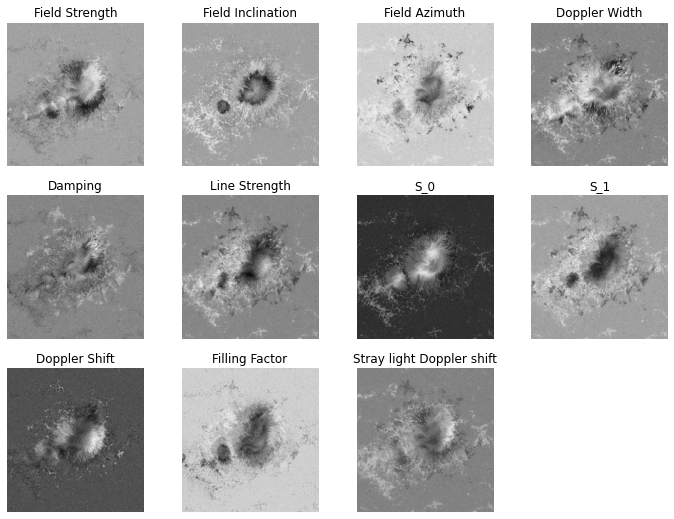

In [12]:
plot_params(predicted_common)

### Model training on the entire dataset

In [13]:
params_full = fits.open('../data/parameters_base.fits')[0].data

In [14]:
full_model = Model(hps)

In [15]:
print("Number of training parameters:", sum(p.numel() for p in full_model.net.parameters() if p.requires_grad))

Number of training parameters: 641766


In [16]:

history = full_model.train(
    data_arr=params_full,
    logdir = '../logs/',
    path_to_save='../models/pi_dist_mlp.pt')

### Loading the trained model

In [ ]:
full_model.load_model('../models/pi_dist_mlp.pt')

In [ ]:
full_predicted_common = full_model.predict_refer('../data/reference.fits')

In [ ]:
full_df_ind = compute_metrics(refer, full_predicted_common, names, save_path = '../res/pi_dist_pred.csv')
full_df_ind

In [ ]:
plot_params(full_predicted_common)